# Classification
This notebook will explore the data from the dataset that was created in `CRW_bleaching.ipynb`. 



## Useful libraries
In this notebook we use the following python libraries. If you are interested you can find more infromation about them in the links below:
- [Pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide): Used for data manipulation and analysis
- [Matplotlib](https://matplotlib.org/stable/tutorials/index.html): Used to visualize data
- [Numpy](https://numpy.org/doc/stable/user/whatisnumpy.html): Used for mathematical operations on vectors and matrices.
- [Seaborn](https://seaborn.pydata.org/): Used to visualize statistical data
- [Scikit learn](https://scikit-learn.org/stable/user_guide.html): Used to pre-process and classify data

In [39]:
%pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
from typing import List

warnings.filterwarnings("ignore")

## Read the table with information from coral reef bleaching
### This data comes from the paper [A global coral-bleaching database, 1980–2020 by van Woesill and Kratochwill 2020](https://www.nature.com/articles/s41597-022-01121-y). A csv file was created from data in their database. 
#### This is an example of incorporating your own data into the Ocean Data Connector

In [3]:
coral_reef_data_df = pd.read_csv("bleaching_data.csv")

## Inspect 
To get a better overview of the data we want to use for our classification it is useful to look into the distribution of the data in question. A nice way of doing this is thorugh a histogram plot showing how the datapoints are distributed.  

In [4]:
# create a function that visualizes the distribution of data points for a list of columns
def plot_multiple_histograms(columns, dataframe):
    num_cols = len(columns)
    inspect_df = dataframe[columns]
    fig, ax = plt.subplots(1, num_cols, sharex="col", sharey="row", figsize=(30, 3))
    for i in range(num_cols):
        inspect_df.hist(column=inspect_df.columns[i], bins=20, ax=ax[i])

### Inspect data that releates to bleaching
In our dataset we have two features that indicate the bleaching level of a reef these are:<br>
`Bleaching_Level` and `Percent_Bleached`<br>
Percent bleached indicates the observed bleaching level of the coral in % while Bleaching level is levels of bleaching ranging from 1-3.

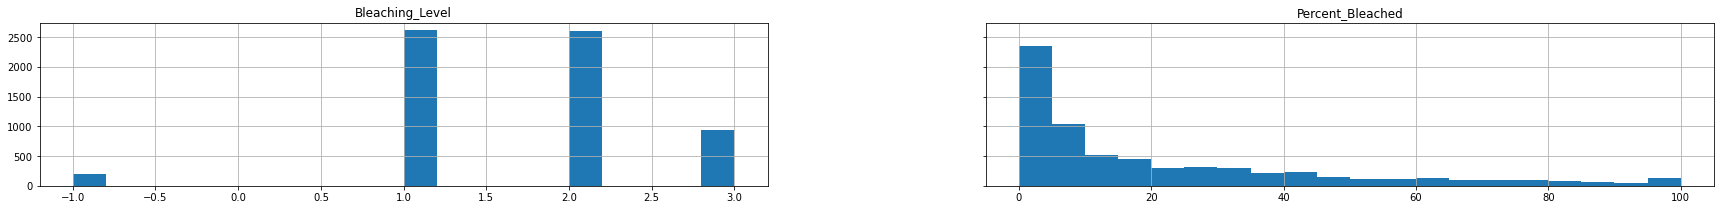

In [5]:
# Pick the columns that relate to bleaching data and plot to get distribution of data
bleaching_cols = ["Bleaching_Level", "Percent_Bleached"]

plot_multiple_histograms(columns=bleaching_cols, dataframe=coral_reef_data_df)

In [6]:
# Create a df that only cotains the two features
bleaching_df = coral_reef_data_df[bleaching_cols]
# Look at how the `Bleaching_Level` relates to `Percent_Bleached`
bleaching_df_not_na = bleaching_df[
    (bleaching_df["Bleaching_Level"].notna())
    & (bleaching_df["Percent_Bleached"].notna())
]
bleaching_df_not_na

,Bleaching_Level,Percent_Bleached
13,1.0,10.000000
14,1.0,8.000000
15,2.0,33.000000
16,1.0,8.000000
21,1.0,0.833333
...,...,...
6058,3.0,78.000000
6059,3.0,83.000000
6060,3.0,87.000000
6061,3.0,98.300000


Take a look at the distribution of the data in the frame<br>
What does this tell us about the data?

In [7]:
bleaching_df_not_na.describe()

,Bleaching_Level,Percent_Bleached
count,2620.000000,2620.000000
mean,2.045038,38.425779
std,0.759988,29.125780
min,1.000000,0.100000
25%,1.000000,9.775000
50%,2.000000,33.333333
75%,3.000000,60.000000
max,3.000000,100.000000


In [8]:
# data in each column
bleaching_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10594 entries, 0 to 10593
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Bleaching_Level   6345 non-null   float64
 1   Percent_Bleached  6861 non-null   float64
dtypes: float64(2)
memory usage: 165.7 KB


In [9]:
# How many null values do we have for each column?
bleaching_df.isnull().sum()

Bleaching_Level     4249
Percent_Bleached    3733
dtype: int64

In [10]:
bleaching_df[bleaching_df.Bleaching_Level == -1]

,Bleaching_Level,Percent_Bleached
17,-1.0,NaN
18,-1.0,NaN
31,-1.0,NaN
43,-1.0,NaN
44,-1.0,NaN
...,...,...
5978,-1.0,NaN
5979,-1.0,NaN
5980,-1.0,NaN
5981,-1.0,NaN


In [11]:
c1 = []
c2 = []
c3 = []
for row in bleaching_df_not_na.iterrows():
    if row[1].Bleaching_Level == 1:
        c1.append(row[1].Percent_Bleached)
    elif row[1].Bleaching_Level == 2:
        c2.append(row[1].Percent_Bleached)
    elif row[1].Bleaching_Level == 3:
        c3.append(row[1].Percent_Bleached)

print(f"Bleaching level \t Number of entries \t Min \t Max")
print(f"1 \t\t\t {len(c1)} \t\t\t {np.min(c1)} \t {np.max(c1)}")
print(f"2 \t\t\t {len(c2)} \t\t\t {np.min(c2)} \t {np.max(c2)}")
print(f"3 \t\t\t {len(c3)} \t\t\t {np.min(c3)} \t {np.max(c3)}")
print(f"total \t\t\t {len(c1)+len(c2)+len(c3)}")

Bleaching level 	 Number of entries 	 Min 	 Max
1 			 700 			 0.1 	 10.0
2 			 1102 			 12.0 	 50.0
3 			 818 			 50.9 	 100.0
total 			 2620


We can observe that there are different measures of bleaching. Some rows only have entries for `Bleaching_Level`, while other rows only have entries for `Percent_Bleached`. Let us create a new column where we try to join the information from these two categories. 

Another observation is that we have a -1 value for the bleaching level. Unfortunately, the creators of the database did not explain what `-1` means in this context, so we will remove it to be safe.

#### Create a column in the table with categorical bleaching data based on information in `Bleaching_Level` and `Percent_Bleached`

In [12]:
# Remove rows where the `Bleaching_Level` is -1
coral_reef_data_df = coral_reef_data_df.where(
    coral_reef_data_df["Bleaching_Level"] != -1
)

# Create a copy of the column `Bleaching_Level` and call it `Categorical_Percent_Bleached`
coral_reef_data_df["Categorical_Percent_Bleached"] = coral_reef_data_df[
    "Bleaching_Level"
]

In [13]:
# Find rows where `Categorical_Percent_Bleached` is not set, and ´Percent_Bleached´ is between 0 and 15 and set the `Categorical_Percent_Bleached` to 1
coral_reef_data_df.loc[
    (
        (coral_reef_data_df["Categorical_Percent_Bleached"].isna())
        & (coral_reef_data_df["Percent_Bleached"] >= 0)
        & (coral_reef_data_df["Percent_Bleached"] < 15)
    ),
    "Categorical_Percent_Bleached",
] = 1

# Find rows where `Categorical_Percent_Bleached` is not set, and ´Percent_Bleached´ is between 15 and 50 and set the `Categorical_Percent_Bleached` to 2
coral_reef_data_df.loc[
    (
        (coral_reef_data_df["Categorical_Percent_Bleached"].isna())
        & (coral_reef_data_df["Percent_Bleached"] >= 15)
        & (coral_reef_data_df["Percent_Bleached"] < 50)
    ),
    "Categorical_Percent_Bleached",
] = 2

# Find rows where `Categorical_Percent_Bleached` is not set, and ´Percent_Bleached´ is above 50 and set the `Categorical_Percent_Bleached` to 3
coral_reef_data_df.loc[
    (
        (coral_reef_data_df["Categorical_Percent_Bleached"].isna())
        & (coral_reef_data_df["Percent_Bleached"] >= 50)
    ),
    "Categorical_Percent_Bleached",
] = 3

# Drop rows where `Categorical_Percent_Bleached` is not set
coral_reef_data_df = coral_reef_data_df.dropna(subset=["Categorical_Percent_Bleached"])

array([[<AxesSubplot:title={'center':'Categorical_Percent_Bleached'}>]],
      dtype=object)

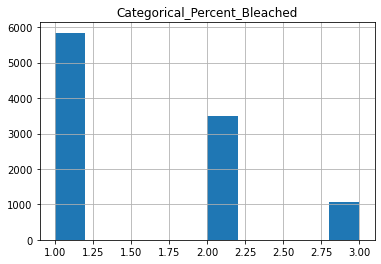

In [14]:
inspect_df = coral_reef_data_df[["Categorical_Percent_Bleached"]]

inspect_df.hist()

We now have a column with one consistent measurement for coral bleaching. Lets move on to our feature evaluation to see what parameters affect coral bleaching.

In the next section we will look into our temperature and thermal stress data and see what effects these features have on coral bleaching.


### Inspect Temperature and Wind data

The temperature data is based on weekly Sea Surface Temperatures ([SSTs](https://climatedataguide.ucar.edu/climate-data/sst-data-sets-overview-comparison-table)) for the study time frame, [created using a harmonics approach](https://journals.ametsoc.org/view/journals/atot/30/7/jtech-d-12-00195_1.xml). Windspeed is also included in this data.


<details><summary>Open to view information about each Temperature and wind parameter</summary>

|Parameter|Description|
|---|---|
|**Temperature_Kelvin**|SST in Kelvin.|
|**Temperature_Mean**|Mean SST in degrees Celsius.|
|**Temperature_Minimum**|Minimum SST in degrees Celsius.|
|**Temperature_Maximum**|Maximum SST in degrees Celsius.|
|**Temperature_Kelvin_Standard_Deviation**|Standard deviation of SST in Kelvin.|
|**Windspeed**|Meters per hour.|
</details>

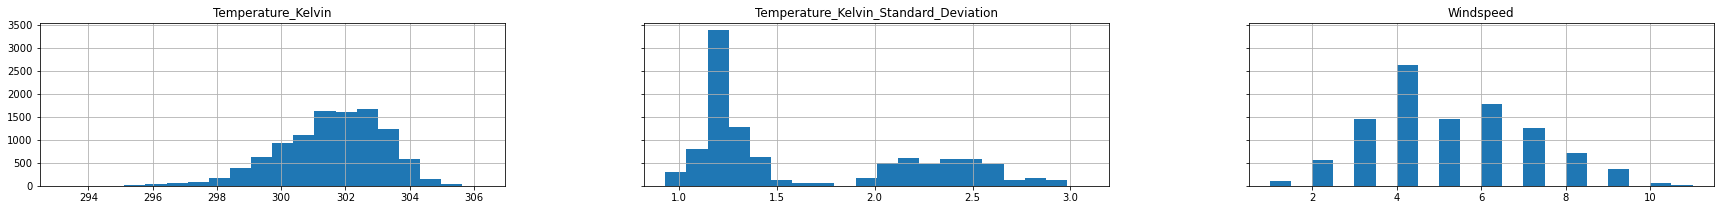

In [15]:
# Inspect Temperature data
temp_cols = ["Temperature_Kelvin"]
all_temp_cols = [
    "Temperature_Kelvin",
    "Temperature_Mean",
    "Temperature_Minimum",
    "Temperature_Maximum",
]
std_cols = ["Temperature_Kelvin_Standard_Deviation"]
wind_cols = ["Windspeed"]
all_cols = temp_cols + std_cols + wind_cols
plot_multiple_histograms(columns=all_cols, dataframe=coral_reef_data_df)

### Challenge 
If you want to, you can try to convert all temprature related columns presented in Kelvin to Celsius [formula](https://climatedataguide.ucar.edu/climate-data/sst-data-sets-overview-comparison-table)


#### Data distribution box plot
A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). It can tell you about your outliers and what their values are. Read more about the method [here](https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51)

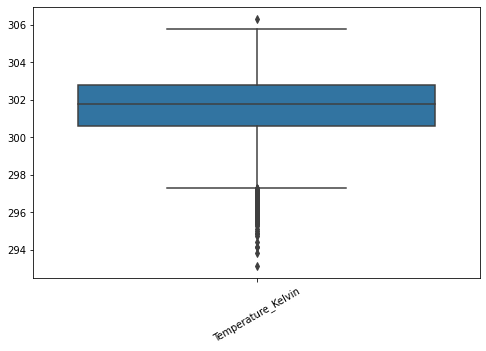

In [16]:
plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=coral_reef_data_df[temp_cols])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

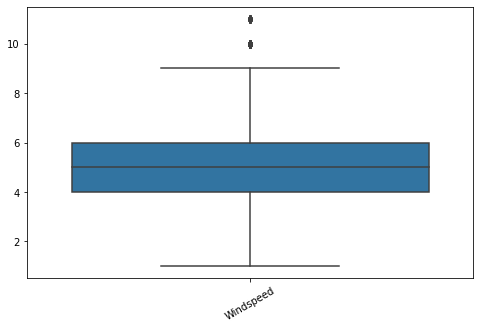

In [17]:
plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=coral_reef_data_df[wind_cols])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

### Challenge 
Should we remove some of our outliers from the table? if so remove them, if not keep them and continue.

### Inspect Sea-Surface Temperature Anomaly (SSTA) data
Some sea surface temperature anomalies are simply transient events, not part of a specific pattern or trend. Other anomalies are more meaningful. At irregular intervals (roughly every 3-6 years), the sea surface temperatures in the Pacific Ocean along the equator become warmer or cooler than normal. These anomalies are the hallmark of El Niño and La Niña climate cycles, which can influence weather patterns across the globe.

Strong, localized sea surface temperature anomalies may reveal that an ocean current, such as the Gulf Stream Current off the east coast of the United States, has veered off its usual path for a time or is stronger or weaker than usual. Sea surface temperature anomalies that persist over many years can be signals of regional or global climate change, such as global warming. The warm anomaly appears to intensify in the Northern Hemisphere summer. This pattern results from the fact that sea ice is retreating to a smaller area in the summer now than in the past; areas that used to be covered with ice all summer are now open water.

Sea surface temperature anomalies have practical as well as scientific applications. For example, in coastal areas, anomalous temperatures (either warm or cool) can favor one organism in an ecosystem over another, causing populations of one kind of bacteria, algae, or fish to thrive or decline. Warm sea surface temperature anomalies can also warn natural resource managers where coral reefs may be in danger of bleaching. 
[Source](https://earthobservatory.nasa.gov/global-maps/AMSRE_SSTAn_M)

The Sea-Surface Temperature Anomaly (SSTA) is the weekly SST minus weekly climatological SST in degrees Celsius.

SSTA_DHW (Sea-Surface Temperature Degree Heating Weeks) is the sum of the previous 12 weeks when SSTA >  = 1 degree Celsius.

<details><summary>Open to view information about each SSTA parameter</summary>

|Parameter|Description|
|---|---|
|**SSTA**|(Sea-Surface Temperature Anomaly) weekly SST minus weekly climatological SST.|
|**SSTA_Standard_Deviation**|The Standard Deviation of weekly SSTA in degrees Celsius over the entire period.|
|**SSTA_Mean**|The mean SSTA in degrees Celsius over the entire period.|
|**SSTA_Minimum**|The minimum SSTA in degrees Celsius over the entire period.|
|**SSTA_Maximum**|The maximum SSTA in degrees Celsius over the entire period.|
|**SSTA_Frequency**|(Sea Surface Temperature Anomaly Frequency) number of times over the previous 52 weeks that SSTA >  = 1 degree Celsius.|
|**SSTA_Frequency_Standard_Deviation**|The standard deviation of SSTA Frequency in degrees Celsius over the entire time period of 40 years.|
|**SSTA_FrequencyMax**|The maximum SSTA Frequency in degrees Celsius over the entire time period.|
|**SSTA_FrequencyMean**|The mean SSTA Frequency in degrees Celsius over the entire time period of 40 years.|
|-|-|
|**SSTA_DHW**|(Sea Surface Temperature Degree Heating Weeks) sum of previous 12 weeks when SSTA > = 1 degree.|
|**SSTA_DHW_Standard_Deviation**|The standard deviation SSTA DHW in degrees Celsius over the entire period.|
|**SSTA_DHWMax**|The maximum SSTA DHW in degrees Celsius over the entire time period of 40 years.|
|**SSTA_DHWMean**|The mean SSTA DHW in degrees Celsius over the entire time period of 40 years.|
    
</details>

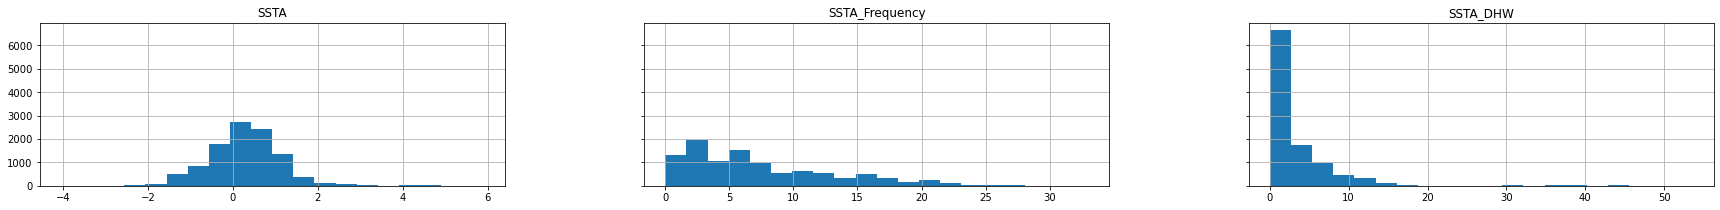

In [18]:
# Inspect SSTA data
ssta_cols = [
    "SSTA",
    "SSTA_Standard_Deviation",
    "SSTA_Mean",
    "SSTA_Minimum",
    "SSTA_Maximum",
    "SSTA_Frequency",
    "SSTA_Frequency_Standard_Deviation",
    "SSTA_FrequencyMax",
    "SSTA_FrequencyMean",
    "SSTA_DHW",
    "SSTA_DHW_Standard_Deviation",
    "SSTA_DHWMax",
    "SSTA_DHWMean",
]
ssta_measurment_cols = ["SSTA", "SSTA_Frequency", "SSTA_DHW"]
plot_multiple_histograms(columns=ssta_measurment_cols, dataframe=coral_reef_data_df)

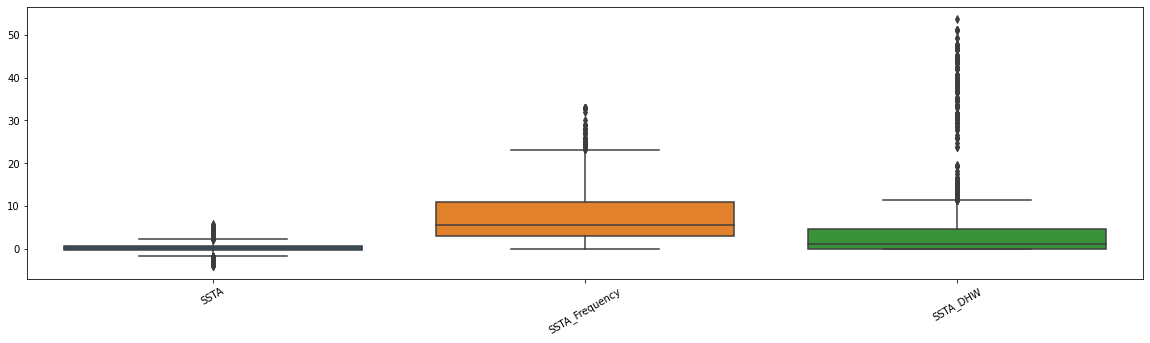

In [19]:
plt.figure(figsize=(20, 5))
ax = sns.boxplot(data=coral_reef_data_df[ssta_measurment_cols])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

Should we remove some of our outliers from the table? if so remove them, if not keep them and continue.

### Inspect Thermal Stress Anomaly (TSA) data

Thermal stress disrupts the symbiotic relationship between the corals and the algae living in their tissues, which causes coral bleaching. [Read more here](https://oceanservice.noaa.gov/facts/coral_bleach.html#:~:text=When%20corals%20are%20stressed%20by,them%20to%20turn%20completely%20white.&text=Warmer%20water%20temperatures%20can%20result%20in%20coral%20bleaching.)

Thermal Stress Anomalies are defined as deviations of 1 week where the temperature was 1 degree Celsius or greater than the mean maximum climatological week(= the long term average warmest week from 1985 to 2005).  

`TSA_DHW` (Thermal Stress Anomaly - Degree Heating Week) is the sum of the previous 12 weeks when TSA >= 1 degree Celsius. 

<details><summary>Open to view information about each TSA parameter</summary>

|Parameter|Description|
|---|---|
|**TSA_Standard_Deviation**|The standard deviation of TSA in degrees Celsius over the entire time period of 40 years.|
|**TSA_Minimum**|The minimum TSA in degrees Celsius over the entire time period of 40 years.|  
|**TSA_Maximum**|The maximum TSA in degrees Celsius over the entire time period of 40 years.|
|**TSA_Mean**|The mean TSA in degrees Celsius over the entire time period of 40 years.|
|**TSA_Frequency**|The number of times over previous 52 weeks that TSA >= 1 degree Celsius.|  
|**TSA_Frequency_Standard_Deviation**|The standard deviation of frequency of TSA in degrees Celsius over the entire time period of 40 years.|  
|**TSA_FrequencyMax**|The maximum TSA frequency in degrees Celsius over the entire time period of 40 years.|  
|**TSA_FrequencyMean**|The mean TSA frequency in degrees Celsius over the entire time period of 40 years.|  
|-|-|
|**TSA_DHW**|Sum of previous 12 weeks when TSA >= 1 degree Celsius. |
|**TSA_DHW_Standard_Deviation**|The standard deviation of TSA DHW in degrees Celsius over the entire time period of 40 years.|
|**TSA_DHWMax**|The maximum TSA DHW in degrees Celsius over the entire time period of 40 years.|
|**TSA_DHWMean**|The mean TSA DHW in degrees Celsius over the entire time period of 40 years|
</details>

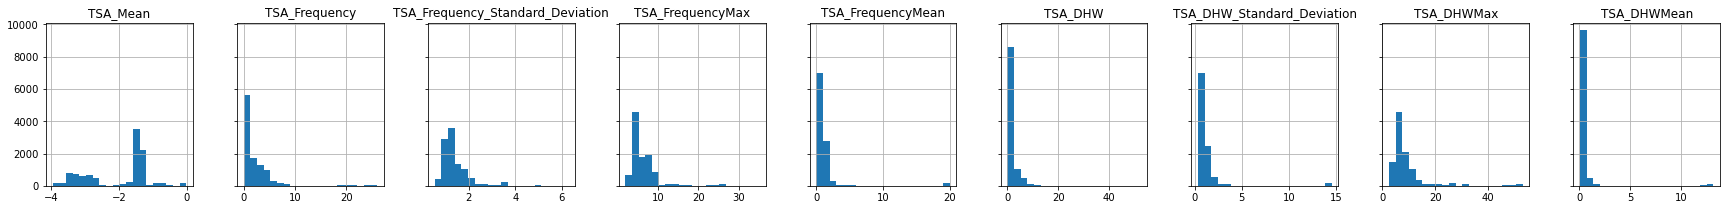

In [20]:
tsa_cols = [
    "TSA_Mean",
    "TSA_Frequency",
    "TSA_Frequency_Standard_Deviation",
    "TSA_FrequencyMax",
    "TSA_FrequencyMean",
    "TSA_DHW",
    "TSA_DHW_Standard_Deviation",
    "TSA_DHWMax",
    "TSA_DHWMean",
]
tsa_measurment_cols = ["TSA_Mean", "TSA_DHW"]
plot_multiple_histograms(columns=tsa_cols, dataframe=coral_reef_data_df)
# choose columns based on available data
tsa_cols = [
    "TSA_Mean",
    "TSA_Frequency",
    "TSA_Frequency_Standard_Deviation",
    "TSA_FrequencyMax",
    "TSA_FrequencyMean",
    "TSA_DHW",
    "TSA_DHW_Standard_Deviation",
    "TSA_DHWMax",
    "TSA_DHWMean",
]

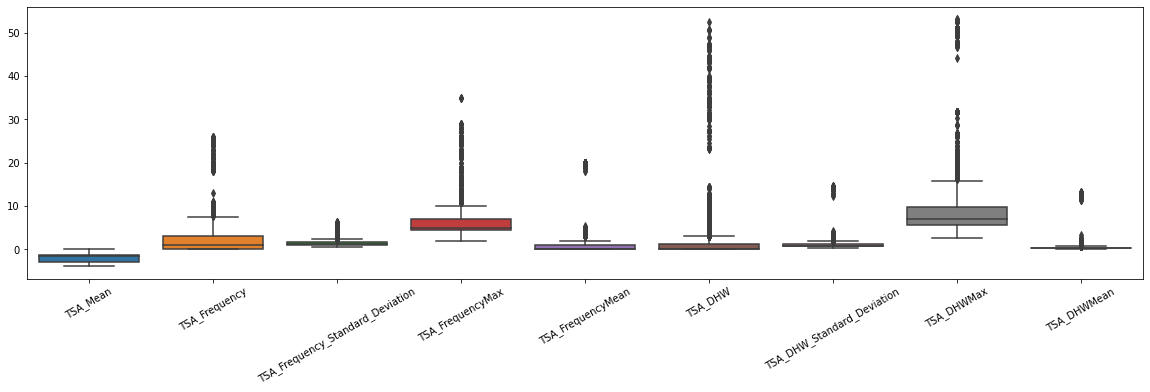

In [21]:
plt.figure(figsize=(20, 5))
ax = sns.boxplot(data=coral_reef_data_df[tsa_cols])
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

### Challenge 
What can we say about these features by looking at their distributions?

### Plot correlation
Correlation is used to find the relationship between two variables, this is often used to predict the value of one variable with the help of other variables, who is being correlated with it.
A good way to quickly check correlations among our selected columns is by visualizing the correlation matrix as a heatmap. The stronger the color, the larger the correlation magnitude. 

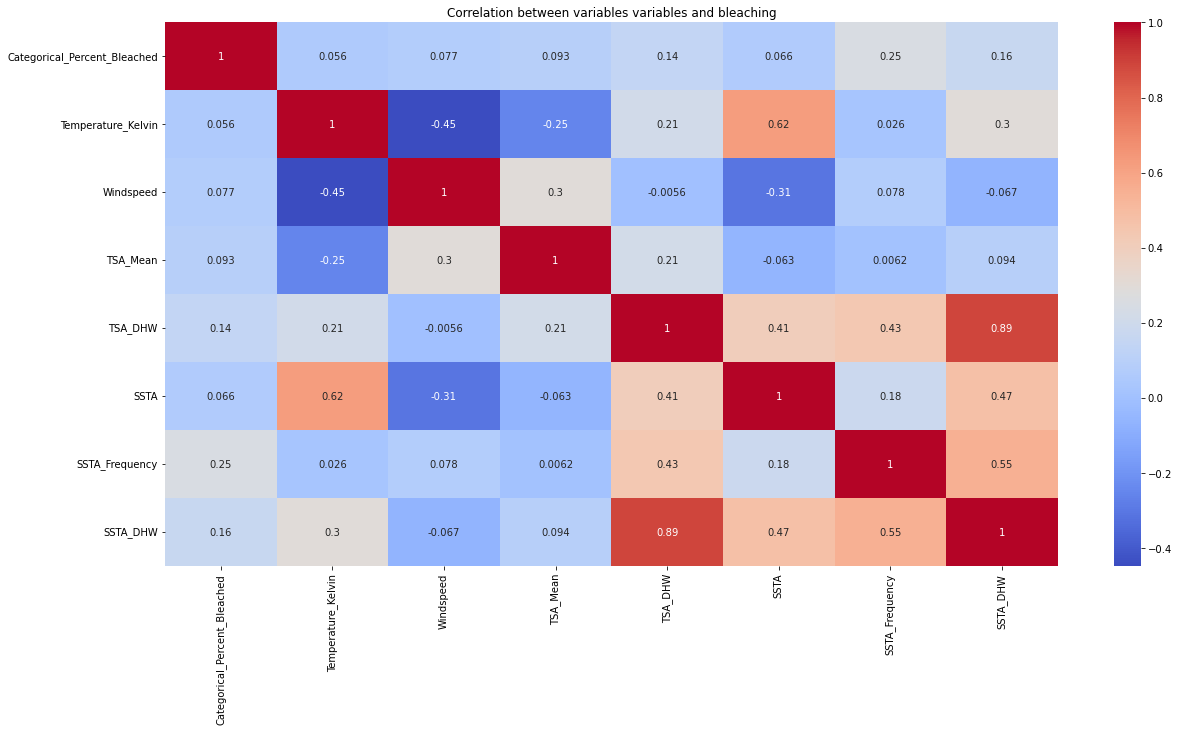

In [22]:
coral_reef_correlation = coral_reef_data_df[
    ["Categorical_Percent_Bleached"]
    + temp_cols
    + wind_cols
    + tsa_measurment_cols
    + ssta_measurment_cols
].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(coral_reef_correlation, annot=True, cmap="coolwarm")
plt.title("Correlation between variables variables and bleaching")
plt.show()

## Select the most important features

### Challenge
Based on the matrix above, which features would you like to select for our classification model? 
Create a dataset based on the selected columns that has values for categorical percent bleached

#### Some suggestions to get you started:
- Feel fre to try out other feature selections methods, a [comprehensive guide can be found here](kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook) 
- You can also try [Principal Component Analysis](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [23]:
# Try other feature selection methos here

In [24]:
# Drop rows that don't have a value for `Categorical_Percent_Bleached`
coral_reef_data_df = coral_reef_data_df.dropna(subset="Categorical_Percent_Bleached")
# Select features that can be used to classify. Are there any features that you wish to remove from our data?
chosen_columns = [
    "TSA_Mean",
    "TSA_Frequency",
    "TSA_Frequency_Standard_Deviation",
    "TSA_FrequencyMax",
    "TSA_FrequencyMean",
    "TSA_DHW",
    "TSA_DHW_Standard_Deviation",
    "TSA_DHWMax",
    "TSA_DHWMean",
    "Temperature_Kelvin",
    "Temperature_Mean",
    "Temperature_Minimum",
    "Temperature_Maximum",
    "Temperature_Kelvin_Standard_Deviation",
    "Windspeed",
    "SSTA",
    "SSTA_Standard_Deviation",
    "SSTA_Mean",
    "SSTA_Minimum",
    "SSTA_Maximum",
    "SSTA_Frequency",
    "SSTA_Frequency_Standard_Deviation",
    "SSTA_FrequencyMax",
    "SSTA_FrequencyMean",
    "SSTA_DHW",
    "SSTA_DHW_Standard_Deviation",
    "SSTA_DHWMax",
    "SSTA_DHWMean",
]

features_df = coral_reef_data_df[chosen_columns]
features_df

,TSA_Mean,TSA_Frequency,TSA_Frequency_Standard_Deviation,TSA_FrequencyMax,TSA_FrequencyMean,TSA_DHW,TSA_DHW_Standard_Deviation,TSA_DHWMax,TSA_DHWMean,Temperature_Kelvin,...,SSTA_Minimum,SSTA_Maximum,SSTA_Frequency,SSTA_Frequency_Standard_Deviation,SSTA_FrequencyMax,SSTA_FrequencyMean,SSTA_DHW,SSTA_DHW_Standard_Deviation,SSTA_DHWMax,SSTA_DHWMean
0,-1.53,0.0,1.18,5.0,0.0,0.0,0.80,6.69,0.23,302.48,...,-3.080000,2.49,0.0,5.17,27.0,4.0,0.00,2.71,18.89,1.43
1,-1.53,0.0,1.18,5.0,0.0,0.0,0.80,6.69,0.23,302.48,...,-3.080000,2.49,0.0,5.17,27.0,4.0,0.00,2.71,18.89,1.43
2,-1.48,0.0,1.00,3.0,0.0,0.0,0.77,4.28,0.26,300.79,...,-2.864286,2.80,3.0,4.74,25.0,4.0,1.01,2.49,16.89,1.44
3,-1.48,0.0,1.00,3.0,0.0,0.0,0.77,4.28,0.26,300.79,...,-2.864286,2.80,3.0,4.74,25.0,4.0,1.01,2.49,16.89,1.44
4,-2.80,3.0,1.41,6.0,1.0,0.0,1.08,8.60,0.36,298.16,...,-3.752222,3.49,6.0,4.88,25.0,7.0,0.00,3.09,19.21,2.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10589,-0.59,0.0,4.95,23.0,5.0,0.0,3.45,24.68,1.86,300.58,...,-3.576250,4.56,3.0,5.78,27.0,8.0,0.00,4.09,28.44,3.19
10590,-0.67,0.0,3.71,18.0,4.0,0.0,2.61,16.57,1.44,300.41,...,-3.478750,3.90,1.0,5.42,24.0,7.0,0.00,3.50,19.29,2.75
10591,-0.67,0.0,3.71,18.0,4.0,0.0,2.61,16.57,1.44,300.41,...,-3.478750,3.90,1.0,5.42,24.0,7.0,0.00,3.50,19.29,2.75
10592,-0.67,0.0,3.71,18.0,4.0,0.0,2.61,16.57,1.44,300.41,...,-3.478750,3.90,1.0,5.42,24.0,7.0,0.00,3.50,19.29,2.75


### Data Normalization
Normalization is a technique often applied as part of data preparation for machine learning. 
The goal of normalization is to change the values of numeric columns in the dataset to a common scale, 
without distorting differences in the ranges of values. For machine learning, every dataset does not require normalization. 
It is required only when features have different ranges.

### Challenge 
Do you have to nomalize the data? If yes, perform the normalization on the selected columns. If no continue on


In [25]:
# Normalize the data

## Building our model
When our model is ready it can take data as input and output if an area is bleached or not. Thus it is important that we create a full data set when traning the model, all our selected feature data will be given as `X`, and our truth `Categorical_Percent_Bleached` will be denoted as `y`. 

In [26]:
full_df = coral_reef_data_df[chosen_columns + ["Categorical_Percent_Bleached"]]
full_df = full_df.dropna()
X_df = full_df[chosen_columns]
# Replace all NaN values with 0  ( should we drop nan instead?)
X = X_df.to_numpy()
X.shape

# Normalize the data w standard scaling
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X)
X_norm = std_scale.transform(X)

In [27]:
y_column = ["Categorical_Percent_Bleached"]
y_df = full_df[y_column]
# Flatten the numpy array.
y = y_df.to_numpy().ravel()
y.shape

(10385,)

## Classifying

When using a supervised algorithm to classify data, it is necessary to provide the classifier with the correct class for each row in the data used for training the classifier. We therefore need to split our data into a training- and a test-dataset. The training data will be used by the classifier optimize it's result. The test-data will be used to evaluate the classifier on data it has not seen before. 

Below we have chosen a classifier called Linear Discriminant Analysis. More information about this classifier can be found [here](https://scikit-learn.org/stable/modules/lda_qda.html#estimation-algorithms).

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [29]:
# split the data into train and test. When we set the `test_size` to 0.2, 80% of the data will be used in the training phase, and 20% will be saved for the test phase.
X = np.nan_to_num(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

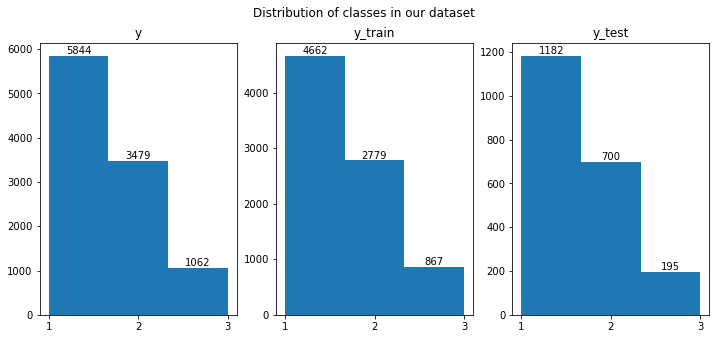

In [30]:
# Let us plot a histogram plot that lets us visualize the number of entries for each category in our dataset, train-dataset and test-dataset.
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
fig.suptitle("Distribution of classes in our dataset")
# y
_, _, bars = axes[0].hist(y, bins=3)
axes[0].set_xticks([1, 2, 3])
axes[0].set_title("y")
axes[0].bar_label(bars)
# y_train
_, _, bars = axes[1].hist(y_train, bins=3)
axes[1].set_xticks([1, 2, 3])
axes[1].set_title("y_train")
axes[1].bar_label(bars)
# y_test
_, _, bars = axes[2].hist(y_test, bins=3)
axes[2].set_xticks([1, 2, 3])
axes[2].set_title("y_test")
axes[2].bar_label(bars)

plt.show()

We clearly have a very imbalanced dataset. The problem with an unbalanced dataset is that one category will be better represented during training. The model can learn to always predict one category, because it will get a high accuracy by predicting the same class over and over. There are a few ways we can work around this. 
- One option is to resample our dataset. [More information can be found in this article.](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb)
    - Undersampling: We can choose fewer entries from the categories where we have a lot of data.
    - Oversampling: We can make copies of the entries in the categories where we have less data. 
- Another option is to use a metric that shows us where the model errs. 
    - The confusion matrix plot illustrates clearly what the model predicts compared to the true label. A model that is not confused has high values on the diagonal, and low elsewhere. 
    - A precision-recall curve shows the tradeoff between precision and recall. A high area under the curve is good, because it represents both high recall and high precision. 

Try to balance the datsets. What are the advantages and disadvatages of the methods? 

In [31]:
clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"accuracy = {accuracy}")

accuracy = 0.601829561868079


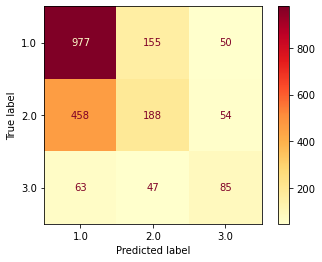

In [32]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf, X_test, y_test, cmap="YlOrRd")

To find a good classifier, it can be necessary to try a few more, and to try to set the parameter of the classifier to something different. Below is a function that tests several classifiers. More information about the classifiers can be found [here](https://scikit-learn.org/stable/modules/multiclass.html).

In [33]:
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC  # (setting multi_class=”crammer_singer”)
from sklearn.ensemble import RandomForestClassifier


def evaluate_classifier(clf, name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f"{name} \t accuracy = {accuracy}")
    return accuracy, name


def evaluate_classifiers(classifiers, names):
    best_accuracy = 0
    best_accuracy_clf = None
    for clf, name in zip(classifiers, names):
        accuracy, clf_name = evaluate_classifier(clf, name)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_accuracy_clf = clf_name
    print(f"\n\nBEST ACCURACY = {best_accuracy} \t {best_accuracy_clf}")


classifiers = [
    LinearDiscriminantAnalysis(),
    BernoulliNB(),
    GaussianNB(),
    DecisionTreeClassifier(),
    KNeighborsClassifier(n_neighbors=3),
    QuadraticDiscriminantAnalysis(),
    RandomForestClassifier(),
    SVC(),
]
names = [
    "LDA",
    "BernoulliNB",
    "GaussianNB",
    "DecisionTreeClassifier",
    "KNeighborsClassifier",
    "QDA",
    "RandomForestClassifier",
    "SVC",
]

evaluate_classifiers(classifiers, names)

LDA 	 accuracy = 0.601829561868079
BernoulliNB 	 accuracy = 0.5445353875782378
GaussianNB 	 accuracy = 0.48579682233991334
DecisionTreeClassifier 	 accuracy = 0.5474241694752047
KNeighborsClassifier 	 accuracy = 0.561386615310544
QDA 	 accuracy = 0.5002407318247473
RandomForestClassifier 	 accuracy = 0.5609051516610496
SVC 	 accuracy = 0.5690900337024555


BEST ACCURACY = 0.601829561868079 	 LDA


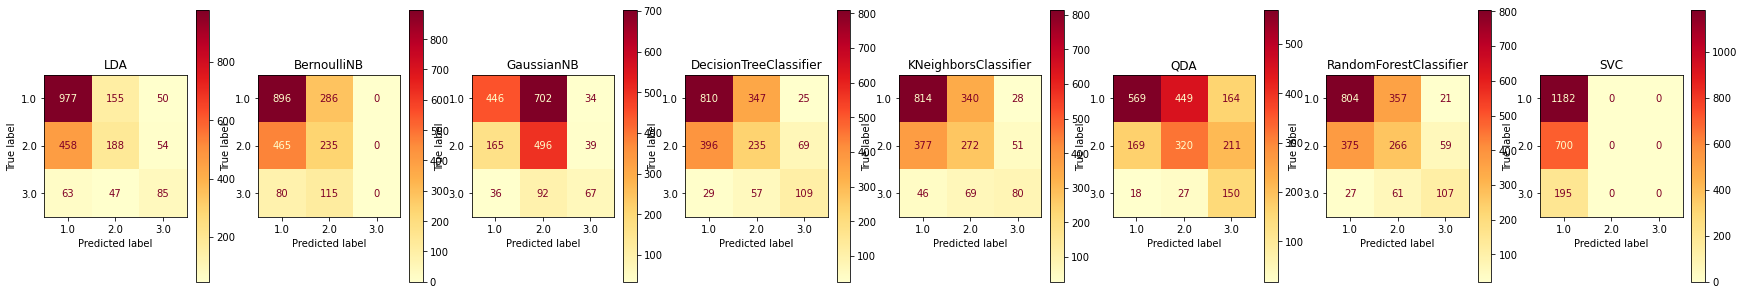

In [34]:
def plot_confusion_matrix_for_multiple_classifiers(classifiers, names):
    fig, axes = plt.subplots(1, len(classifiers), figsize=(30, 5))
    for i in range(len(classifiers)):
        clf = classifiers[i]
        name = names[i]
        clf.fit(X_train, y_train)
        plot_confusion_matrix(clf, X_test, y_test, ax=axes[i], cmap="YlOrRd")
        axes[i].set_title(name)
    plt.show()


plot_confusion_matrix_for_multiple_classifiers(classifiers, names)

### Precision-Recall

Precision-Recall is a measure of the accuracy and relevance of the results. 
Precision is defined as $P = \frac{T_p}{T_p + F_p}$, where $T_p$ is the number of true positives and $F_p$ is the number of false positives. 
Recall is defined as $R = \frac{T_p}{T_p + F_n}$, where $F_n$ is the number of false negatives. 

A more thorough guide on Precision and Recall can be found [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#:~:text=The%20precision%2Drecall%20curve%20shows,a%20low%20false%20negative%20rate.).

In [35]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

In [36]:
# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[1, 2, 3])
n_classes = Y.shape[1]

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
# create a classification pipeline
classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), QuadraticDiscriminantAnalysis())
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

In [37]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

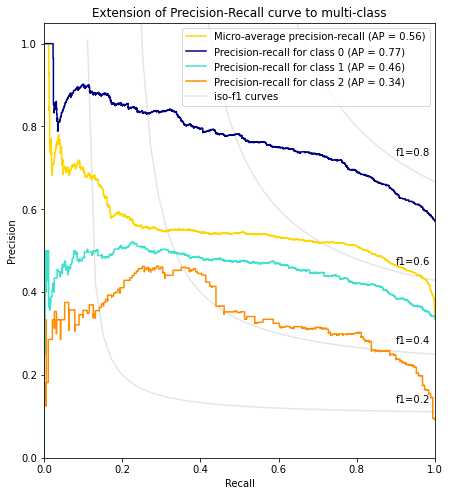

In [38]:
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

### Challenge 
What can you conclude about the precision and recall of this model?<br>
In this specific use-case, which do you think is more important to optimize for, precision or recall? If you have time you can tune the model to get better precision or recall based on your decision.